In [1]:
!pip install dtreeviz

You should consider upgrading via the 'C:\Users\LUCAS\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


## Random Forest

### Cargo el Dataset

In [2]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
ds_hotels = pd.read_csv("./hotels_modificado_train.csv")
ds_h = ds_hotels.copy() 
pd.set_option('display.max_columns', None)

In [4]:
def agent_a_string(value):
    return str(value)
ds_h["agent"] = ds_h["agent"].apply(agent_a_string)
ds_h[ds_h.duplicated("id")]
ds = ds_h.drop(["id"], axis="columns", inplace=False)
filas_totales=ds.shape[0]
print(ds.isna().sum()/filas_totales*100)

hotel                             0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
market_segment                    0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
assigned_room_type                0.0
booking_changes                   0.0
deposit_type                      0.0
agent                             0.0
days_in_waiting_list              0.0
customer_type                     0.0
adr                               0.0
required_car

### Preprocesamiento de datos y division de estos

One Hot Encoding para variables categoricas

In [5]:
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment", 
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent", 
"customer_type"]
ds = pd.get_dummies(ds, columns=var_cual, drop_first=True)

Divido el Dataset: 75% para train y 25% para test

In [6]:
#Creo un dataset con los features que voy a usar para clasificar
ds_x=ds.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_y = ds['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=4, #semilla
                                                    stratify=ds["is_canceled"].values) 

### Creo el RF

Una vez tengamos todo el dataset listo nos preparamos para armar el random Forest. Para esto necesitamos saber cuales son sus hiperparametros por defecto.

In [7]:
rfc_default = RandomForestClassifier()
rfc_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Cuando ya vimos los hiperparametros armamos un random forest con estos elegidos arbitrariamente

In [8]:
#Creamos un clasificador con hiperparámetros arbitrarios
rfc = RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50 )
#Entrenamos el modelo
model = rfc.fit(X = x_train, y = y_train)

In [9]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [10]:
#Probemos verlos juntos en un DataFrame
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head()

,test,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1


Accuracy: 0.8109191307445671
Recall: 0.695512082853855
f1 score: 0.740051426472389


Text(50.722222222222214, 0.5, 'True')

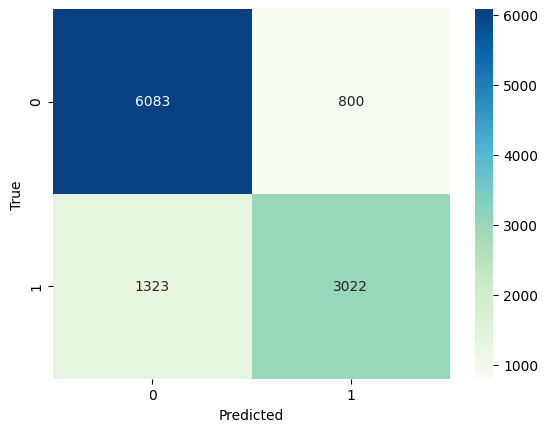

In [11]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Grafico del Arbol

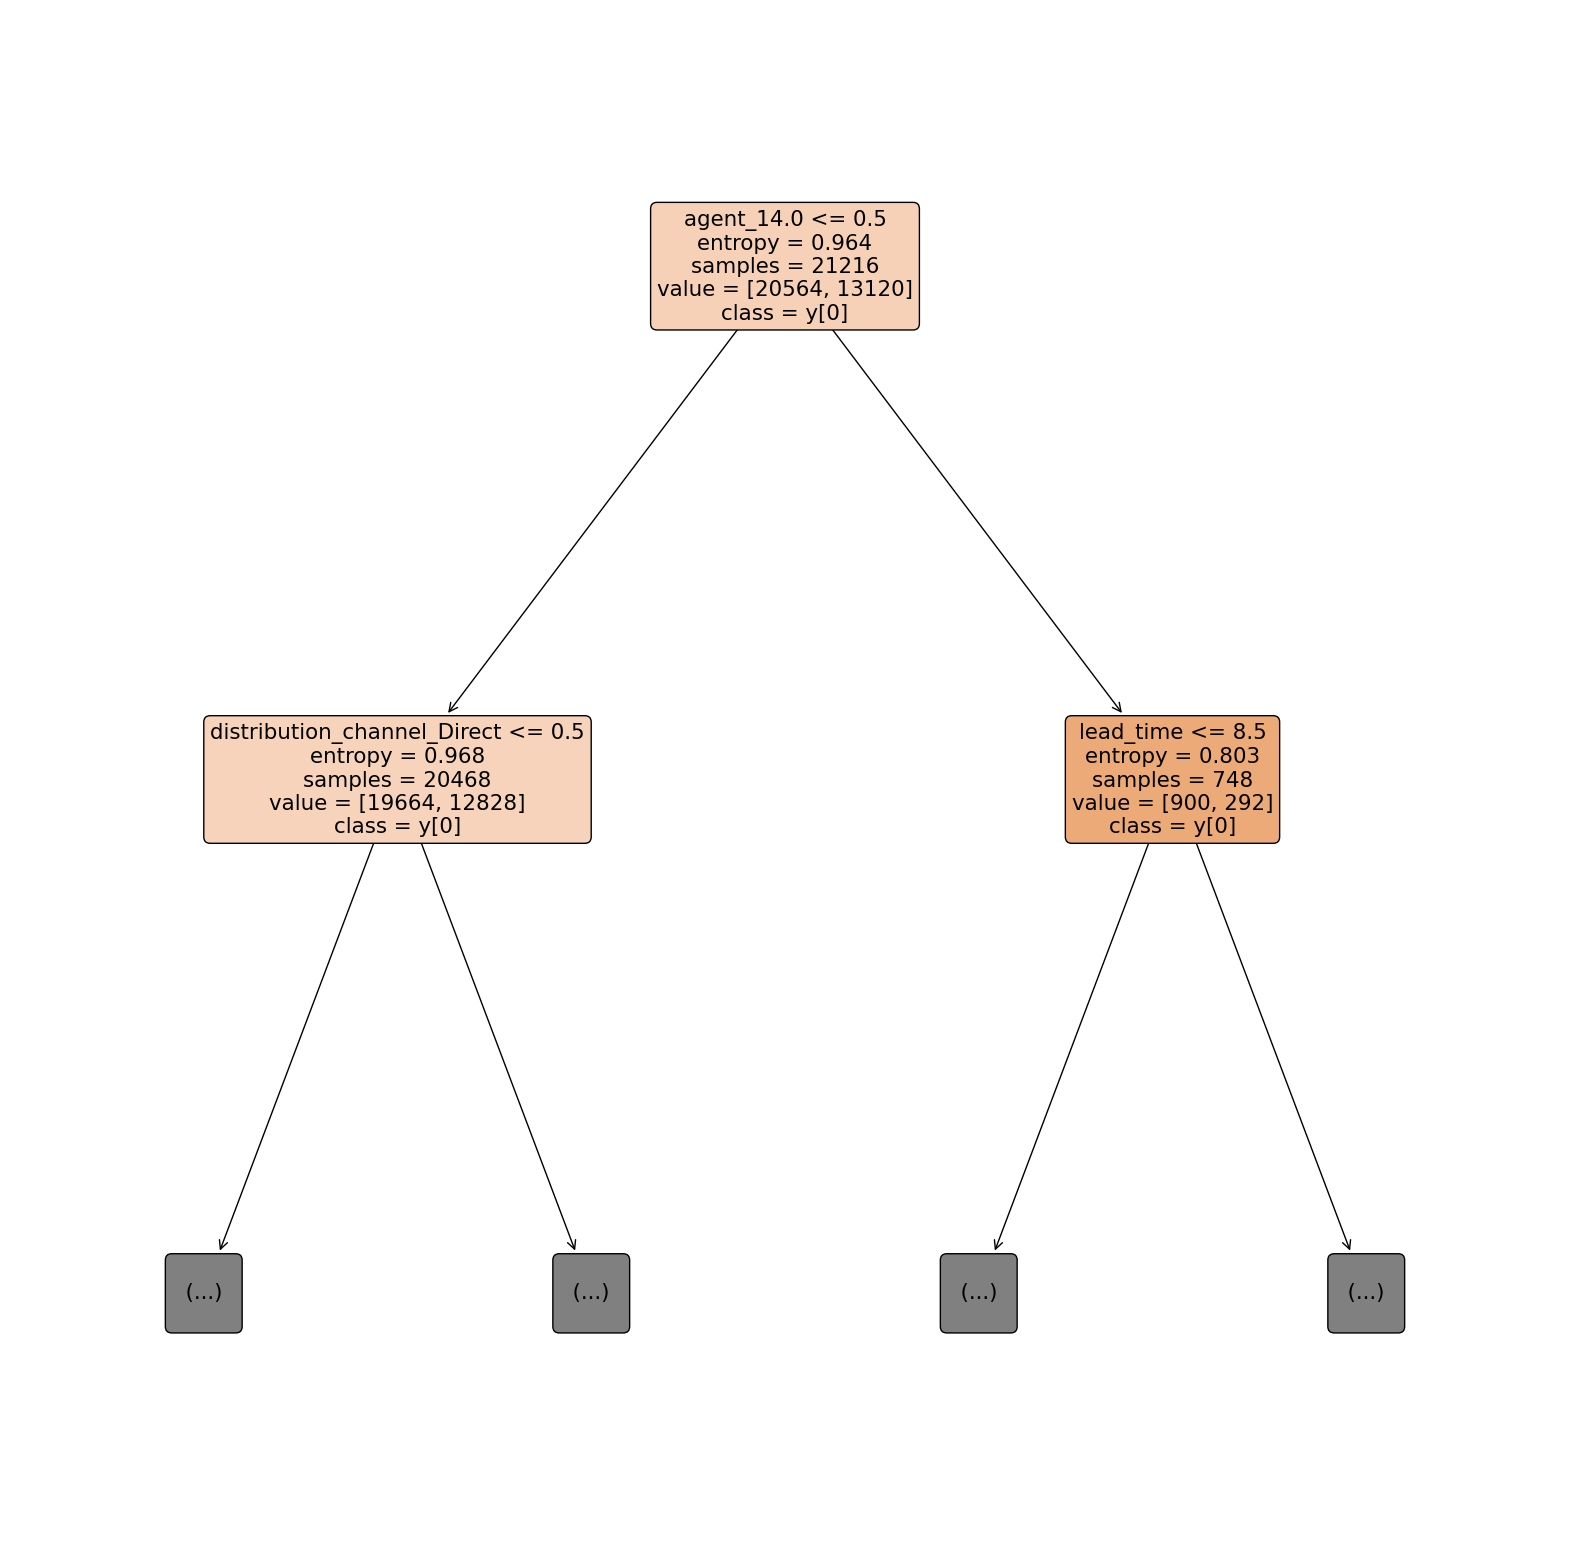

In [12]:
plt.figure(figsize=(20,20))

tree_plot=tree.plot_tree(model.estimators_[10],
                         max_depth=1,
                         feature_names=ds_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [13]:
sorted(list(zip(ds_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('lead_time', 0.10369544681156985),
 ('country_PRT', 0.10278450069317274),
 ('required_car_parking_spaces', 0.07446480484993682),
 ('total_of_special_requests', 0.05355232138172954),
 ('market_segment_Online TA', 0.050716623875616026),
 ('customer_type_Transient', 0.0380654503201843),
 ('market_segment_Offline TA/TO', 0.03719818046342143),
 ('adr', 0.034636556517288086),
 ('deposit_type_Non Refund', 0.03241479276355615),
 ('agent_9.0', 0.028875986982389888),
 ('previous_cancellations', 0.02695122642276668),
 ('distribution_channel_TA/TO', 0.023620572417296908),
 ('agent_240.0', 0.022110620428121966),
 ('arrival_date_year', 0.02073354703073123),
 ('stays_in_week_nights', 0.020465211939620857),
 ('booking_changes', 0.01945395397786314),
 ('customer_type_Transient-Party', 0.018946925729693493),
 ('arrival_date_week_number', 0.018077121661680646),
 ('country_GBR', 0.015861438222931536),
 ('arrival_date_day_of_month', 0.013765250468474913),
 ('agent_7.0', 0.013390298968202203),
 ('hotel_Re

### Busquemos hiperparametros con GridSearch CrossValidation

In [14]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10,20, 50] }

#Entrenamos con varias métricas
metricas=['accuracy','f1','roc_auc','recall','precision']

gs_multimetrica = GridSearchCV(estimator=rf_cv, 
                               param_grid=param_grid, 
                               scoring=metricas, 
                               refit=False, 
                               cv=5, 
                               n_jobs=-1)
#Entrenamiento
gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

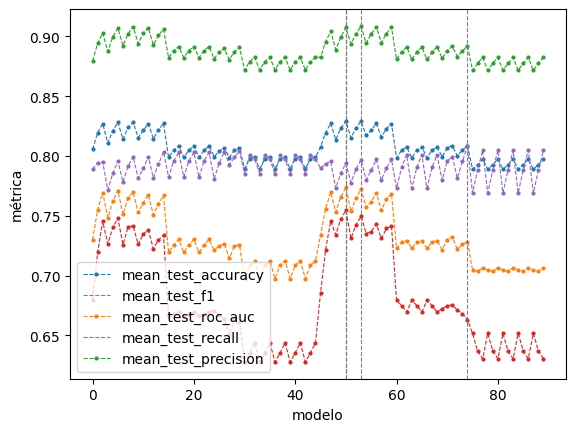

In [15]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)     
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')
        
plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels)
plt.show()

La mejor combinación de hiperparámetros

In [16]:
params_elegidos=gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_accuracy'])]
params_elegidos

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

### Creamos el RF con los mejores hiperparametros

In [17]:
#Creamos un clasificador RF
rfc_multimetrica = RandomForestClassifier(criterion= params_elegidos['criterion'], 
                                          min_samples_leaf= params_elegidos['min_samples_leaf'], 
                                          min_samples_split= params_elegidos['min_samples_split'], 
                                          n_estimators=params_elegidos['n_estimators'], 
                                          oob_score=True, random_state=2, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)

#Hacemos una predicción
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(x_test)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6883
           1       0.79      0.76      0.78      4345

    accuracy                           0.83     11228
   macro avg       0.82      0.82      0.82     11228
weighted avg       0.83      0.83      0.83     11228



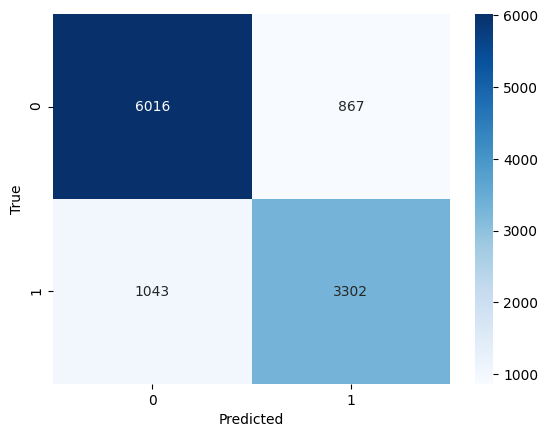

In [18]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_model_rfc_multimetrica)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_model_rfc_multimetrica))

Como podemos observar mejoro principalmente el Recall. Esto quiere decir que los predicts que realizamos en general fueron la mayoria true positive en vez de false negative. Tambien mejoro el F1 score, esto quiere decir que en general el modelo fue mas preciso con sus predicciones.

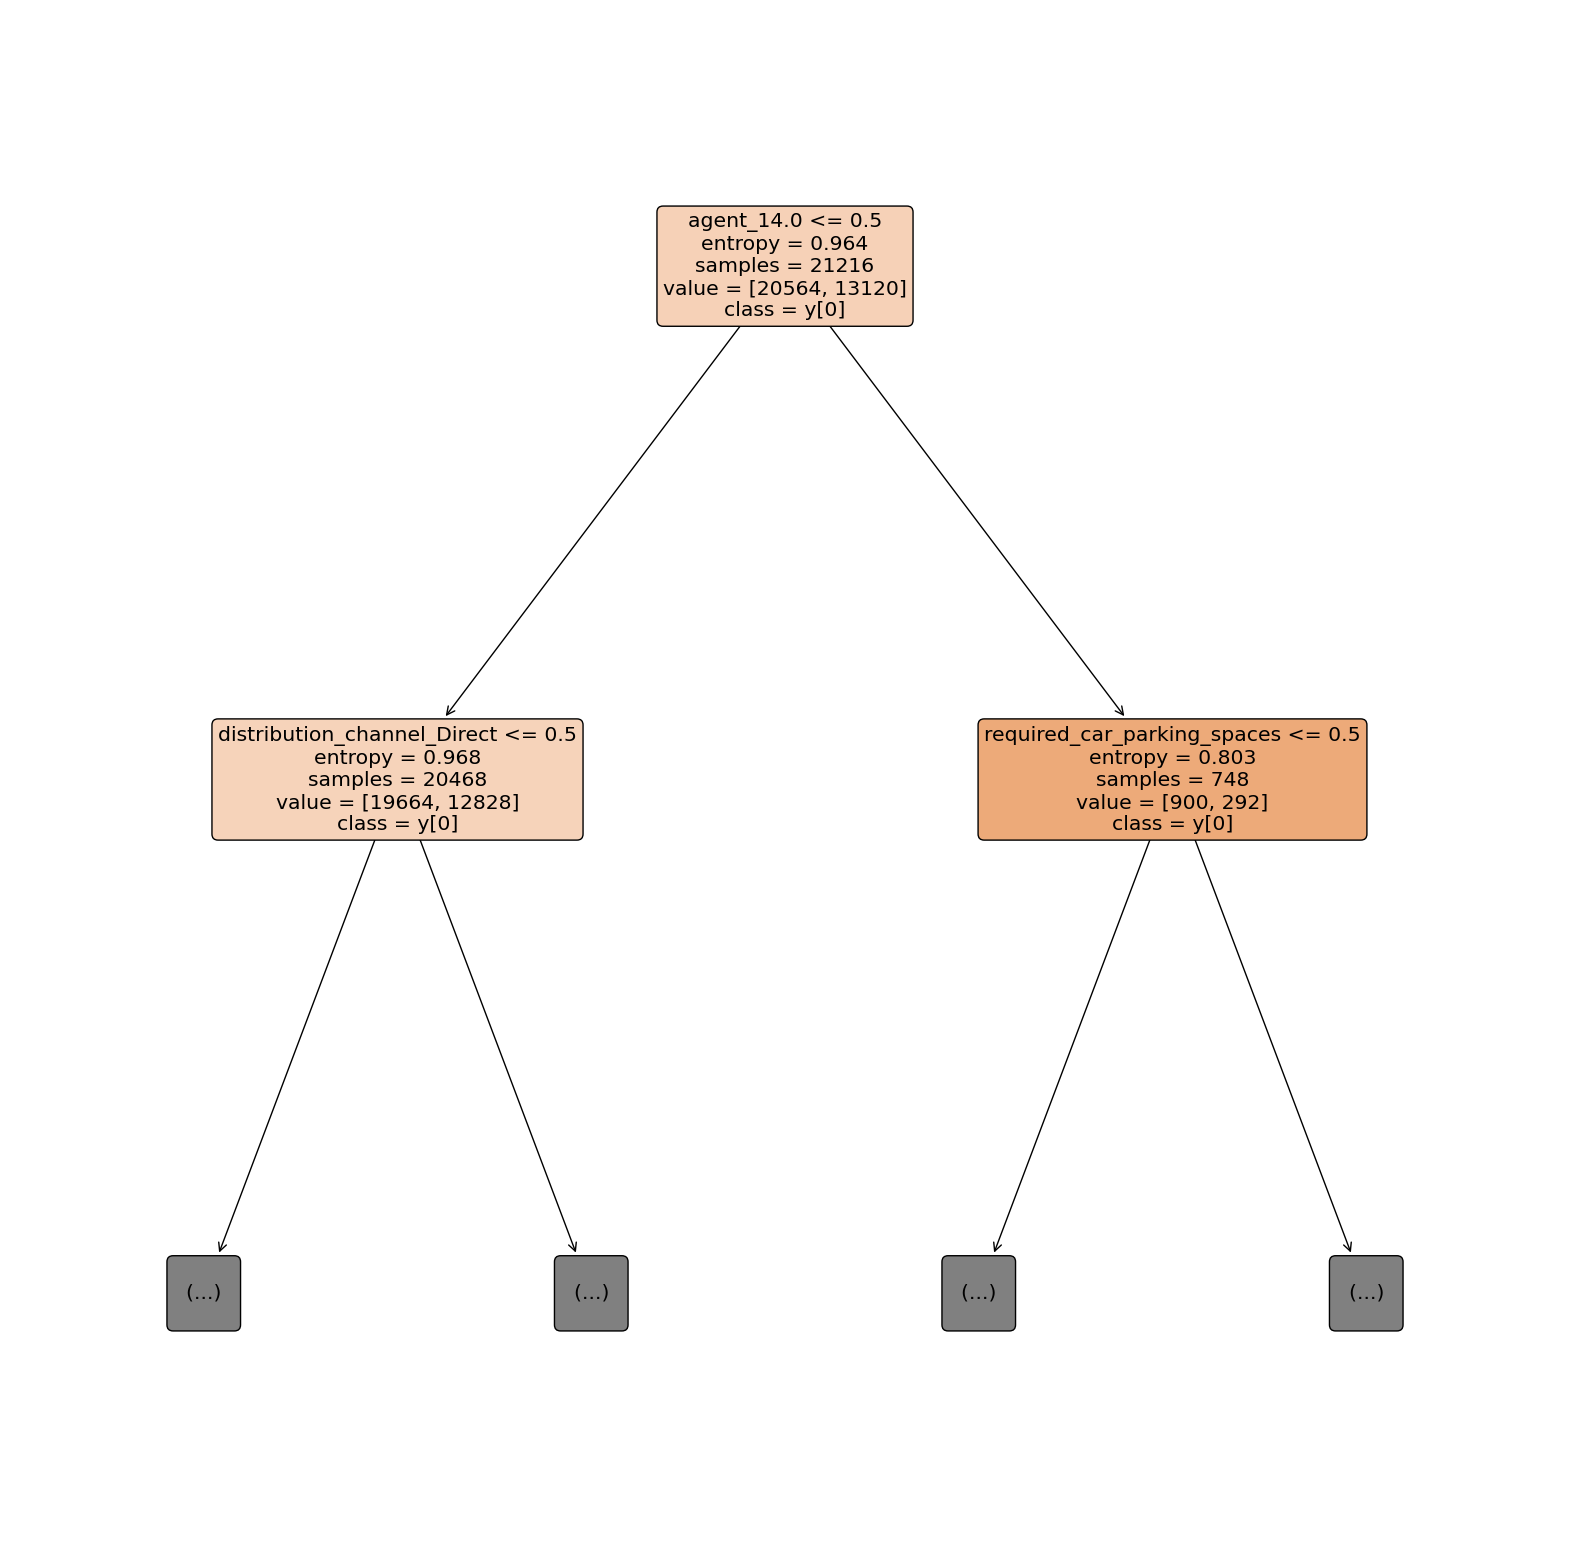

In [19]:
plt.figure(figsize=(20,20))

tree_plot_multimetrica=tree.plot_tree(model_rfc_multimetrica.estimators_[10],
                         max_depth=1,
                         feature_names=ds_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot_multimetrica)

In [20]:
sorted(list(zip(ds_x.columns.to_list(), model_rfc_multimetrica.feature_importances_)), key=lambda x: -x[1])

[('lead_time', 0.10639845617278727),
 ('adr', 0.06773527549499722),
 ('country_PRT', 0.057961977097477344),
 ('arrival_date_day_of_month', 0.0542315108239493),
 ('arrival_date_week_number', 0.05102475059861816),
 ('total_of_special_requests', 0.05010362380813229),
 ('stays_in_week_nights', 0.03975971582939913),
 ('required_car_parking_spaces', 0.03834276322557275),
 ('stays_in_weekend_nights', 0.0260083062593953),
 ('arrival_date_year', 0.025828681385559434),
 ('market_segment_Online TA', 0.022090028446048224),
 ('agent_9.0', 0.018490671436023686),
 ('customer_type_Transient', 0.018043055938040942),
 ('booking_changes', 0.017571211918766688),
 ('previous_cancellations', 0.01712876232152329),
 ('deposit_type_Non Refund', 0.016101394770401248),
 ('adults', 0.014819819614105447),
 ('country_GBR', 0.012597349617274784),
 ('market_segment_Offline TA/TO', 0.012094330158760522),
 ('agent_240.0', 0.011967658715788553),
 ('customer_type_Transient-Party', 0.011327623731750846),
 ('assigned_room_

### Pre Procesamiento de Datos de hotel_test

In [21]:
ds_hotels_test = pd.read_csv("./hotels_test.csv")
ds_h_test = ds_hotels_test.copy()
ds_h_test.drop(columns="reservation_status_date", inplace=True)

In [22]:
filas_totales=ds_hotels_test.shape[0]
print(ds_h_test.isna().sum()/filas_totales*100)

hotel                              0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.000000
babies                             0.000000
meal                               0.000000
country                            0.358018
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                       0.000000
agent                           

Como podemos observar tenemos datos con Nulls. Utilizaremos la mediana que calculamos para cada una de esas columnas en hotel_train y se la pondremos a hotel_test para asi conseguir una mejor prediccción de los datos

In [23]:
ds_h_test.drop(columns= 'company', inplace = True)

In [24]:
ds_h_test.isin(['Undefined']).sum()

hotel                               0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            0
babies                              0
meal                              238
country                             0
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car

In [25]:
#One hot encoding para variables categoricas
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment", 
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent", 
"customer_type"]
ds_h_test = pd.get_dummies(ds_h_test, columns=var_cual, drop_first=True)

ds_h_test.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,id,hotel_Resort Hotel,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ALB,country_AND,country_ARE,country_ARG,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_BEL,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KHM,country_KOR,country_KWT,country_LBN,country_LBY,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MOZ,country_MWI,country_MYS,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_PRY,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VNM,country_ZAF,country_ZWE,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,agent_2.0,agent_3.0,agent_4.0,agent_5.0,agent_6.0,agent_7.0,agent_8.0,agent_9.0,agent_10.0,agent_11.0,agent_12.0,agent_13.0,agent_14.0,agent_15.0,agent_16.0,agent_17.0,agent_19.0,agent_20.0,agent_21.0,agent_22.0,agent_23.0,agent_25.0,agent_26.0,agent_27.0,agent_28.0,agent_29.0,agent_30.0,agent_31.0,agent_32.0,agent_33.0,agent_34.0,agent_35.0,agent_36.0,agent_37.0,agent_38.0,agent_39.0,agent_40.0,agent_41.0,agent_42.0,agent_44.0,agent_45.0,agent_47.0,agent_50.0,agent_52.0,agent_53.0,agent_55.0,agent_56.0,agent_57.0,agent_58.0,agent_60.0,agent_61.0,agent_63.0,agent_64.0,agent_66.0,agent_67.0,agent_68.0,agent_69.0,agent_71.0,agent_72.0,agent_74.0,agent_75.0,agent_77.0,agent_78.0,agent_79.0,agent_81.0,agent_82.0,agent_83.0,agent_85.0,agent_86.0,agent_87.0,agent_88.0,agent_89.0,agent_91.0,agent_92.0,agent_94.0,agent_95.0,agent_96.0,agent_98.0,agent_99.0,agent_103.0,agent_104.0,agent_105.0,agent_106.0,agent_110.0,agent_111.0,agent_112.0,agent_115.0,agent_118.0,agent_119.0,agent_121.0,agent_122.0,agent_126.0,agent_127.0,agent_128.0,agent_12

In [26]:
print(ds_h_test.isna().sum()/filas_totales*100)

lead_time                        0.0
arrival_date_year                0.0
arrival_date_week_number         0.0
arrival_date_day_of_month        0.0
stays_in_weekend_nights          0.0
                                ... 
agent_527.0                      0.0
agent_531.0                      0.0
customer_type_Group              0.0
customer_type_Transient          0.0
customer_type_Transient-Party    0.0
Length: 461, dtype: float64


Para poder hacer el predict saco las columnas nuevas que me quedaron en el encoding y agrego las que tenia en el dataframe con el cual entrene al arbol que uso e inicializandolas en _false_

In [27]:
# Agarramos las columnas diferentes de ds
diff_cols_df2 = set(ds.columns) - set(ds_h_test.columns)

# Agrego las columnas faltantes en ds_h_test y las inicializo en false
for col in diff_cols_df2:
    ds_h_test[col] = np.False_

# Solo me quedo con las columnas de ds_h_test que esten en ds
df_test = ds_h_test[ds.columns]

In [28]:
ds_kag = df_test.drop(["is_canceled"], axis="columns", inplace=True)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_12352\2483917292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Utilizo Pipeline para reemplazar datos nulls con la mediana encontrada en ds para cada valor

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
pipeline = Pipeline([  ('imputer', imputer)])
pipeline.fit(ds)

# Obtener lista de columnas de ds
cols_ds = ds.columns

# Seleccionar solo las columnas presentes en ds en ds_h_test
cols_ds_h_test = [col for col in df_test.columns if col in cols_ds]

# Aplicar pipeline solo a las columnas presentes en ambos dataframes
pipeline.fit(ds[cols_ds_h_test])
df_test[cols_ds_h_test] = pipeline.transform(df_test[cols_ds_h_test])

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_12352\3663599621.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Hacemos el Predict para Kaggle

In [30]:
y_pred_kaggle = model_rfc_multimetrica.predict(df_test)

In [31]:
ds_kaggle = pd.DataFrame({'id': ds_h_test['id'], 'is_canceled': y_pred_kaggle})

In [32]:
ds_kaggle.to_csv('pred_kaggle_RF.csv', index=False)

### Guardamos el Random Forest

In [45]:
# Guardar el arbol
import joblib
filename = 'arbol_rf.sav'
joblib.dump(model_rfc_multimetrica, filename)

['arbol_rf.sav']

## Ensamble híbrido tipo Stacking

In [33]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
from collections import defaultdict

In [34]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(modelo, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    scores = cross_val_score(modelo, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [35]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

Armamos el ensamble con los modelos: Random Forest, SVM y KNN. Y como meta modelo utilizo regresion logistica con CrossValidation

In [36]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=11)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  9.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    5.1s finished


In [37]:
#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

In [39]:
#Evaluo en conjunto de test
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
accuracy_score(y_test, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


0.8303348770929818

### Armamos la matriz de confusion para el ensamble hibrido de tipo stacking

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      6883
           1       0.79      0.77      0.78      4345

    accuracy                           0.83     11228
   macro avg       0.82      0.82      0.82     11228
weighted avg       0.83      0.83      0.83     11228



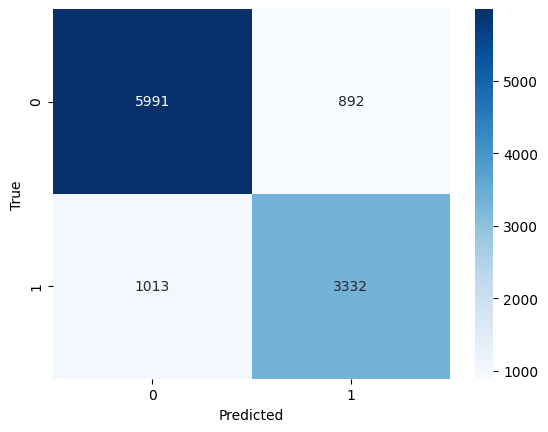

In [40]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_st)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_st))

Como podemos observar tuvimos una mayor cantidad de precision en comparacion al Random Forest. Osea que la cantidad de true positives fue mayor en proporcion a los false positives.

### Hacemos el Predict para Kaggle

In [41]:
y_pred_kaggle_hibrido_stacking = stacking_model.predict(df_test)

In [42]:
ds_kaggle_hibrido_stacking = pd.DataFrame({'id': ds_h_test['id'], 'is_canceled': y_pred_kaggle_hibrido_stacking})

In [43]:
ds_kaggle_hibrido_stacking.to_csv('pred_kaggle_H_Stacking.csv', index=False)

### Guardamos el Ensamble Hibrido Tipo Stacking

In [44]:
# Guardar el arbol
import joblib
filename = 'ensamble_h_stacking.sav'
joblib.dump(stacking_model, filename)

['ensamble_h_stacking.sav']